# Problem

In this assignment you will implement one or more algorithms for the traveling salesman problem, such as the dynamic programming algorithm covered in the video lectures.
Here is a data file describing a TSP instance.
- tsp.txt

The first line indicates the number of cities.
Each city is a point in the plane, and each subsequent line indicates the x- and y-coordinates of a single city.

The distance between two cities is defined as the Euclidean distance --- that is, two cities at locations $(x,y)$ and $(z,w)$ have distance $\sqrt{(x - z)^2 + (y - w)^2}$ between them.

In the box below, type in the minimum cost of a traveling salesman tour for this instance, rounded down to the nearest integer.

OPTIONAL: If you want bigger data sets to play with, check out the TSP instances from around the world [here](http://www.math.uwaterloo.ca/tsp/world/countries.html).
The smallest data set (Western Sahara) has 29 cities, and most of the data sets are much bigger than that.
What's the largest of these data sets that you're able to solve --- using dynamic programming or, if you like, a completely different method?

HINT: You might experiment with ways to reduce the data set size.
For example, trying plotting the points.
Can you infer any structure of the optimal solution?
Can you use that structure to speed up your algorithm?

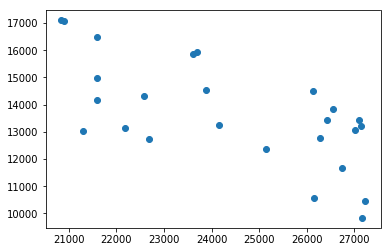

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cities(filename):
    ncities = 0
    X, Y = [], []
    for n, line in enumerate(open(filename)):
        if n == 0:
            ncities = int(line[0])
        else:
            x, y = map(float, line.split())
            X.append(x)
            Y.append(y)
    
    plt.scatter(X, Y)
    plt.show()
    
    return ncities, X, Y

n, X, Y = plot_cities("tsp.txt")